In [127]:
import requests
import datetime
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import schedule

%matplotlib inline

### Function on information extraction on Justin Trudeau

This function calls the Guardian Media API and queries the information on a given date.
Cleans the response and extracts the no of articles posted and stores the titles and section information and returns it

In [2]:
def total_articles_dataCleaning(start_date, query, title_flag):

# API endpoint     
    endPoint = "https://content.guardianapis.com/search"
# Default page number to start with
    page_no = 1
# counter for total articles
    total_articles = 0

# Query input parameters along with it's filters
    params = {
        "from-date": str(start_date),
        "to-date": str(start_date),
        "api-key": "test",
        "q": str(query),
        "order-by": "oldest",
        "page": str(page_no)
    }
# Obtaining the response from the GuardianAPI
    response = requests.get(endPoint, params)
    
    Articles_List = response.json()['response']['results']
    articles_count = len(Articles_List)
    
    
    section_names = []
    article_titles = []
    valid_articles = 0
    
    while ((response.status_code ==200) and (articles_count != 0)):
        
        Articles_List = response.json()['response']['results']
        
        for article in Articles_List:
            webTitle = article['webTitle']
            
            if (("trudeau" in webTitle.lower()) or (title_flag)):
                section_names.append(article['sectionName'])
                article_titles.append(webTitle)
                valid_articles = valid_articles + 1
        
        page_no = page_no + 1
        params['page'] = str(page_no)
        
        response = requests.get(endPoint, params)
        
        articles_count = len(Articles_List)
        
    
    return valid_articles, article_titles, section_names

### This function calls the function for Information Extraction and stores the cleaned response into dictionaries

In [128]:
def date_query(start_date, query, title_flag):
    
    
#Today is the end date
    end_date = datetime.datetime.now().date()
    delta = datetime.timedelta(days=1)

# This dictionary will be converted to a Dataframe later on
# This dictionary saves the information on the given query for the range of dates
    ts_guardian = {
        "Date": [],
        "No. of Articles": [],
        "Article_Names": [],
        "Section": []
    } 
    while start_date <= end_date:

        Total_articles, Names, Sections = total_articles_dataCleaning(start_date, query, title_flag)

        ts_guardian['Date'].append(start_date)
        ts_guardian['No. of Articles'].append(Total_articles)
        ts_guardian['Article_Names'].append(Names)
        ts_guardian['Section'].append(Sections)

        #print('date:' , start_date, "Articles: ", Total_articles)

        start_date += delta

    return ts_guardian

### Function to count sections

In [90]:
def count_sections(df):
    section_counts = {}
    sections = list(df.iloc[:,3])

    for L in sections:
        for s in L:
            if s in section_counts.keys():
                section_counts[s] = section_counts[s] + 1 
            else:
                section_counts[s] = 1


    section_counts
    section_counts = sorted(section_counts.items(), key = lambda x: x[1], reverse=True)

    return section_counts[0]

### Function to make graphs of two input dataframes (Plot)

In [38]:
def plot_graph_frames(df1, df2):
    plt.figure(figsize=(16, 9), dpi=360)
    SMALL_SIZE = 6
    MEDIUM_SIZE = 8
    POST_MEDIUM_SIZE = 10
    plt.rc('font', size=MEDIUM_SIZE)
    plt.rc('axes', titlesize=MEDIUM_SIZE)

    plt.subplot(2,1,1)

    plt.title("Articles mentioning Justin Trudeau", fontsize=POST_MEDIUM_SIZE)
    plt.xlabel("Time Progression", fontsize=MEDIUM_SIZE)
    plt.ylabel("No. of articles", fontsize=MEDIUM_SIZE)
    plt.plot(df1.iloc[:,0], df1.iloc[:,1], linewidth='1.25')

    plt.subplot(2,1,2)

    plt.title("Articles about Justin Trudeau", fontsize=POST_MEDIUM_SIZE)
    plt.xlabel("Time Progression", fontsize=MEDIUM_SIZE)
    plt.ylabel("No. of articles", fontsize=MEDIUM_SIZE)
    plt.plot(df2.iloc[:,0], df2.iloc[:,1], linewidth='1.25')

    plt.subplots_adjust(wspace=None, hspace=0.25)
    plt.show()   

### Function to make graphs of two input dataframes (Scatter)

In [36]:
def scatter_graph_frames(df1, df2):
    plt.figure(figsize=(16, 9), dpi=360)
    SMALL_SIZE = 6
    MEDIUM_SIZE = 8
    POST_MEDIUM_SIZE = 10
    plt.rc('font', size=MEDIUM_SIZE)
    plt.rc('axes', titlesize=MEDIUM_SIZE)

    plt.subplot(2,1,1)

    plt.title("Articles mentioning Justin Trudeau", fontsize=POST_MEDIUM_SIZE)
    plt.xlabel("Time Progression", fontsize=MEDIUM_SIZE)
    plt.ylabel("No. of articles", fontsize=MEDIUM_SIZE)
    plt.scatter(df1.iloc[:,0], df1.iloc[:,1], s=1.5)

    plt.subplot(2,1,2)

    plt.title("Articles about Justin Trudeau", fontsize=POST_MEDIUM_SIZE)
    plt.xlabel("Time Progression", fontsize=MEDIUM_SIZE)
    plt.ylabel("No. of articles", fontsize=MEDIUM_SIZE)
    plt.scatter(df2.iloc[:,0], df2.iloc[:,1], s=1.5)

    plt.subplots_adjust(wspace=None, hspace=0.25)
    plt.show()   

In [130]:
# execution starts here
start_date = datetime.date(2018,1,1)
query = "Justin Trudeau"

# Articles which contain Justin Truduea's Name
results_dict_1 = date_query(start_date, query, True)

# Articles which have Justin Trudeau's name in their Title
results_dict_2 = date_query(start_date, query, False)

In [7]:
df_mentions = pd.DataFrame(results_dict_1)
df_titles = pd.DataFrame(results_dict_2)

output_mentions = df_mentions[['Date', 'No. of Articles']] 
output_titles = df_titles[['Date', 'No. of Articles']]

### Output of the collected articles where Justin Trudeau's name is either in the Titles OR in the Body

This refers to the articles which mention Justin Trudeau in any capacity. Whether or not the article is actually about him

In [8]:
output_mentions

,Date,No. of Articles
0,2018-01-01,2
1,2018-01-02,1
2,2018-01-03,2
3,2018-01-04,0
4,2018-01-05,1
...,...,...
1778,2022-11-14,5
1779,2022-11-15,1
1780,2022-11-16,6
1781,2022-11-17,4


### This output is of the collected articles which focus on Justin Trudeau. 

To filter the articles which have Justin Trudeau as a focus person, I have resorted to picking only the articles which contain Trudeau's name in their titles.

In [89]:
output_titles

,Date,No. of Articles
0,2018-01-01,0
1,2018-01-02,0
2,2018-01-03,0
3,2018-01-04,0
4,2018-01-05,0
...,...,...
1778,2022-11-14,0
1779,2022-11-15,1
1780,2022-11-16,0
1781,2022-11-17,1


#### _Question-2:_ How Many articles have been posted in total
#### _Question-3:_ Averages of All days and Total Articles Posted

In [6]:
print("Articles which Contain Justin Trudeau in their Title OR in their Body")
print("Total posted articles until today: ", sum(df_mentions.iloc[:,1]))
average_mentions = sum(df_mentions.iloc[:,1])/len(df_mentions)
print("Average articles per day: ", average_mentions)

print("Articles which Contain Justin Trudeau in their Title Only")
print("Total posted articles until today: ", sum(df_titles.iloc[:,1]))
average_titles = sum(df_titles.iloc[:,1])/len(df_titles)
print("Average articles per day: ", average_titles)

Articles which Contain Justin Trudeau in their Title OR in their Body
Total posted articles until today:  3455
Average articles per day:  1.9377453729669096
Articles which Contain Justin Trudeau in their Title Only
Total posted articles until today:  164
Average articles per day:  0.09197980931015143


### _Question-4:_ Sections with Most Articles

here we send the origina dataframes as an argument to the function which will count the number of articles by section and will return the section name with most articles.

*It can be seen cleary that the Section with most articles for both data frames is:* __World News__

In [92]:
print("For the DataFrame where Articles mention Justin Trudeau in Title OR Body")
print("Section with Most Articles: ", count_sections(df_mentions))

print()
print("For the DataFrame where Articles mention Justin Trudeau in Title")
print("Section with Most Articles: ", count_sections(df_titles))

For the DataFrame where Articles mention Justin Trudeau in Title OR Body
Section with Most Articles:  ('World news', 960)

For the DataFrame where Articles mention Justin Trudeau in Title
Section with Most Articles:  ('World news', 127)


### _Question-5:_ Evolution of No. of Articles over given time period 

I am demonstrating this with the following two graphs for a time series evolution.

The X-axes are representative of the time series
The Y-axes are representative of the No. of Articles

#### Plot of evolution

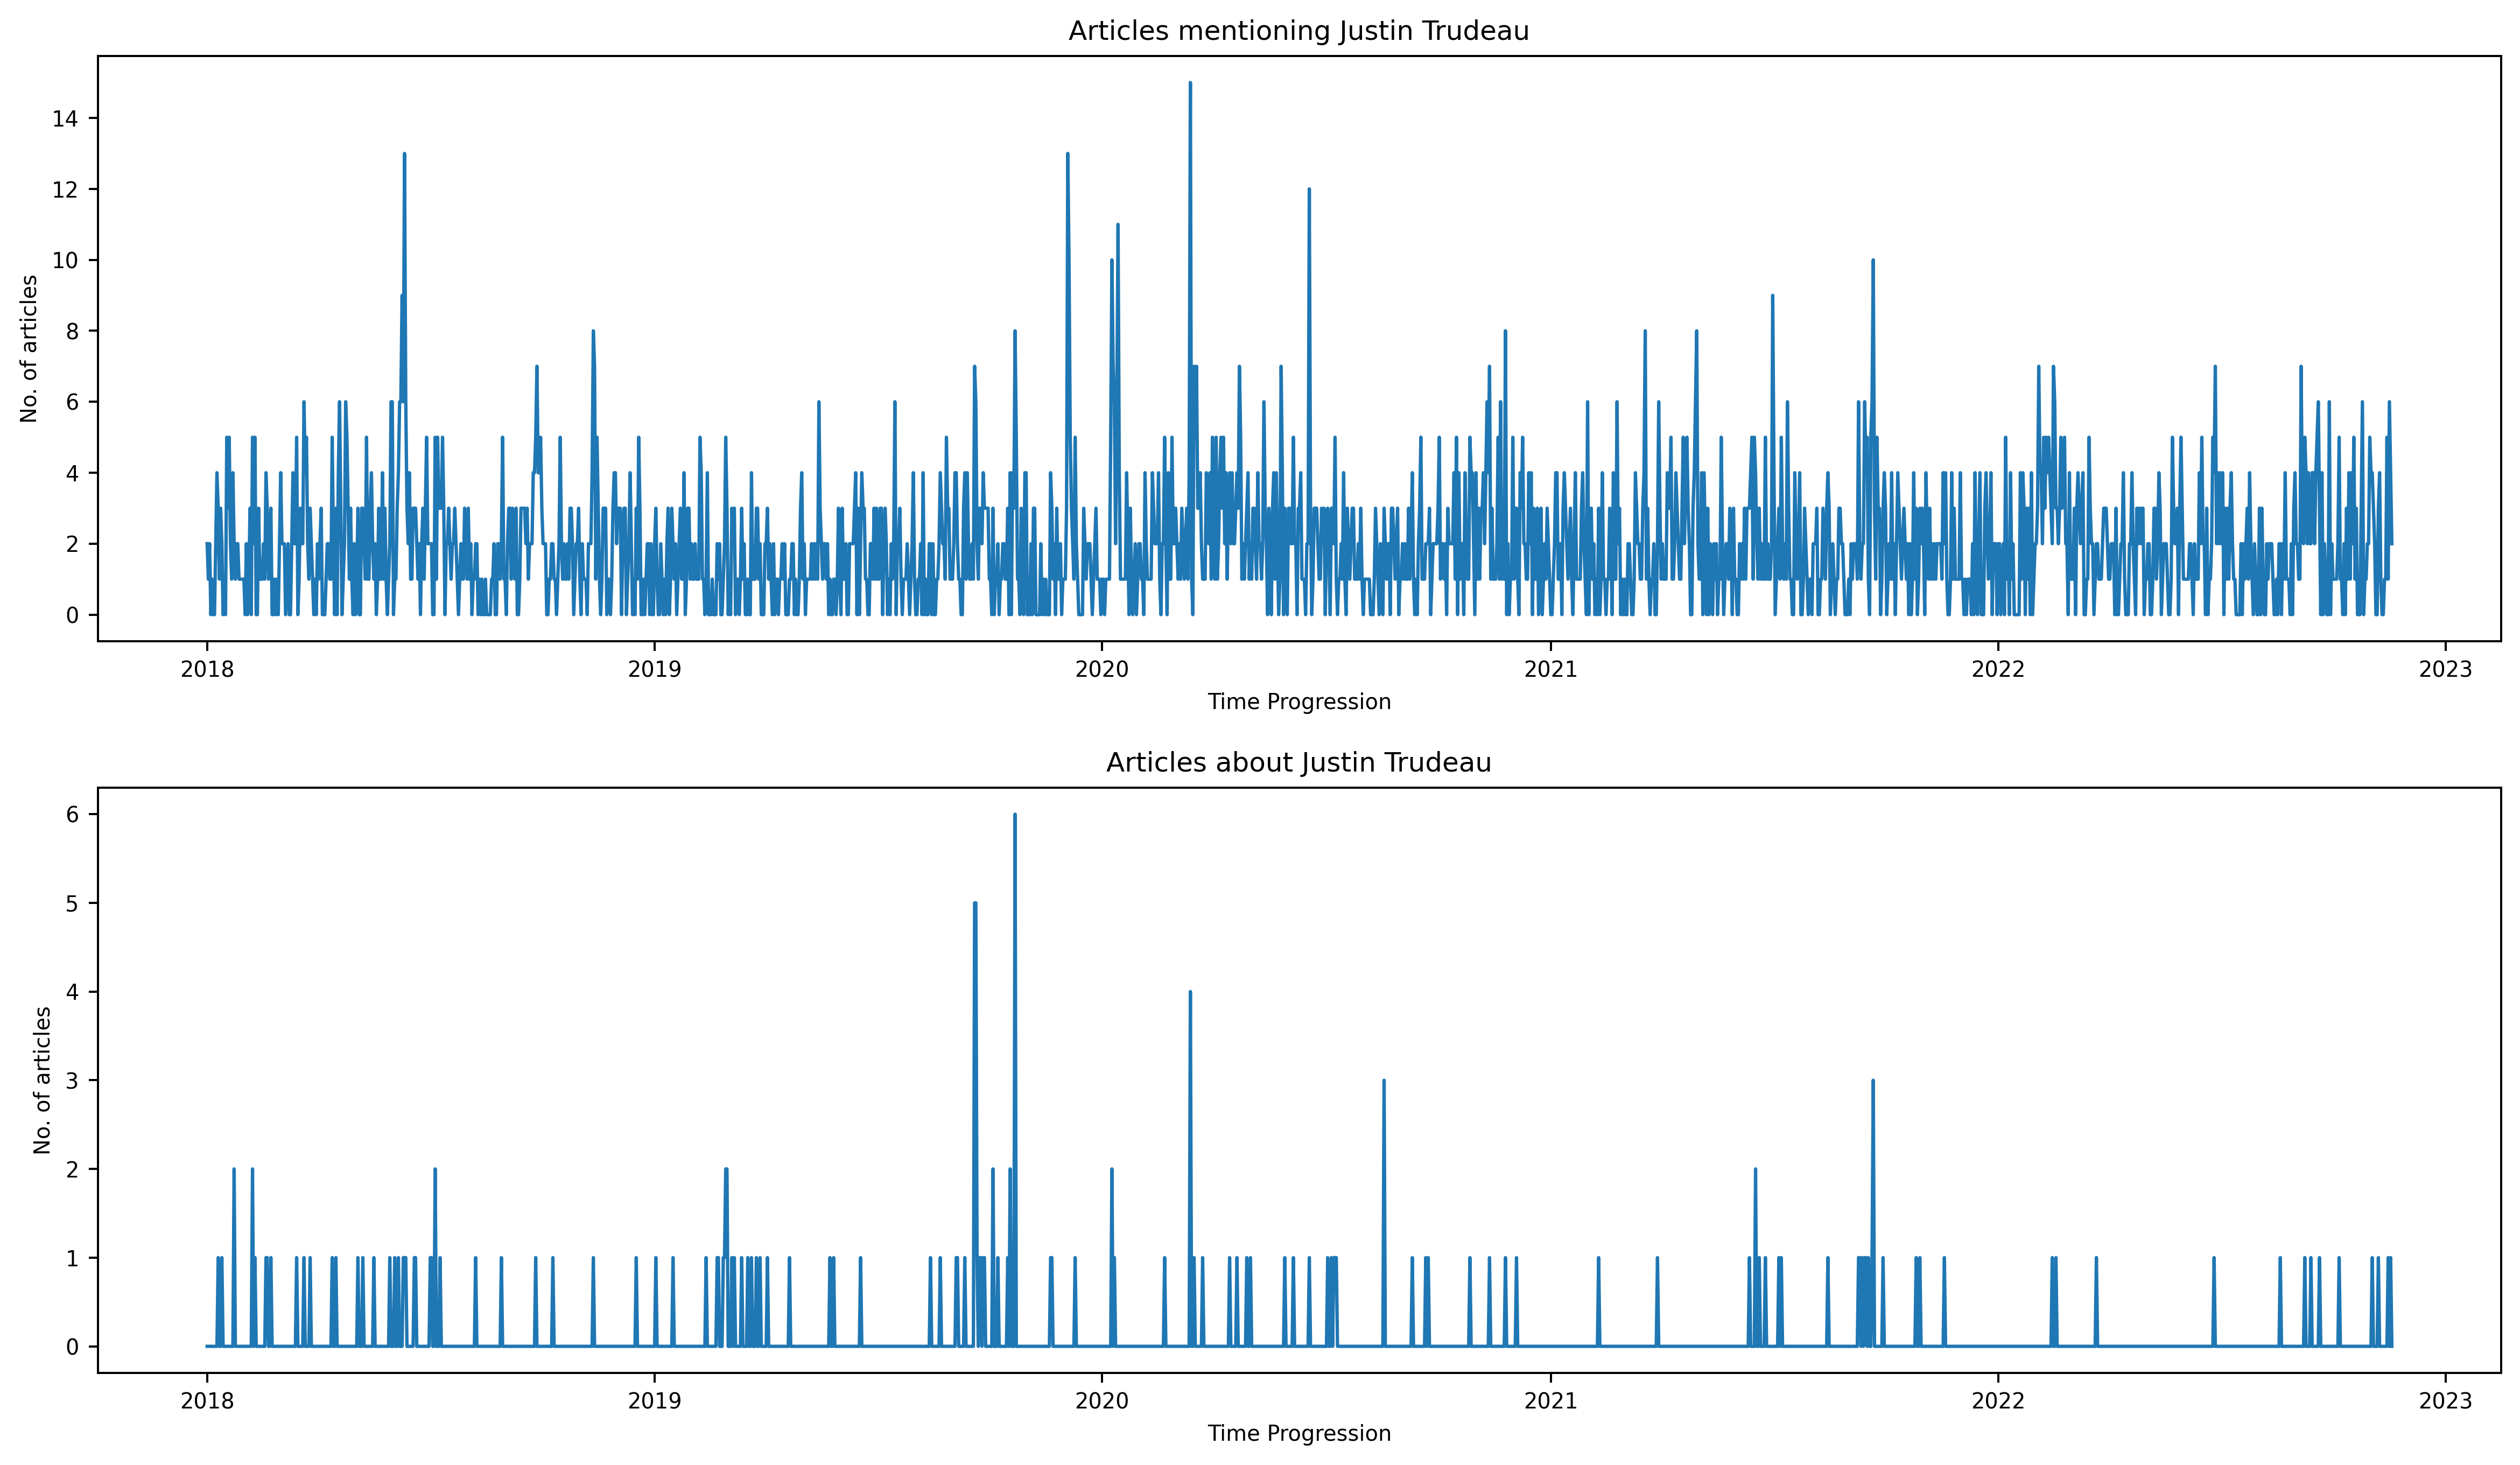

In [39]:
plot_graph_frames(df_mentions,df_titles)

#### Scatter plot of time evolution

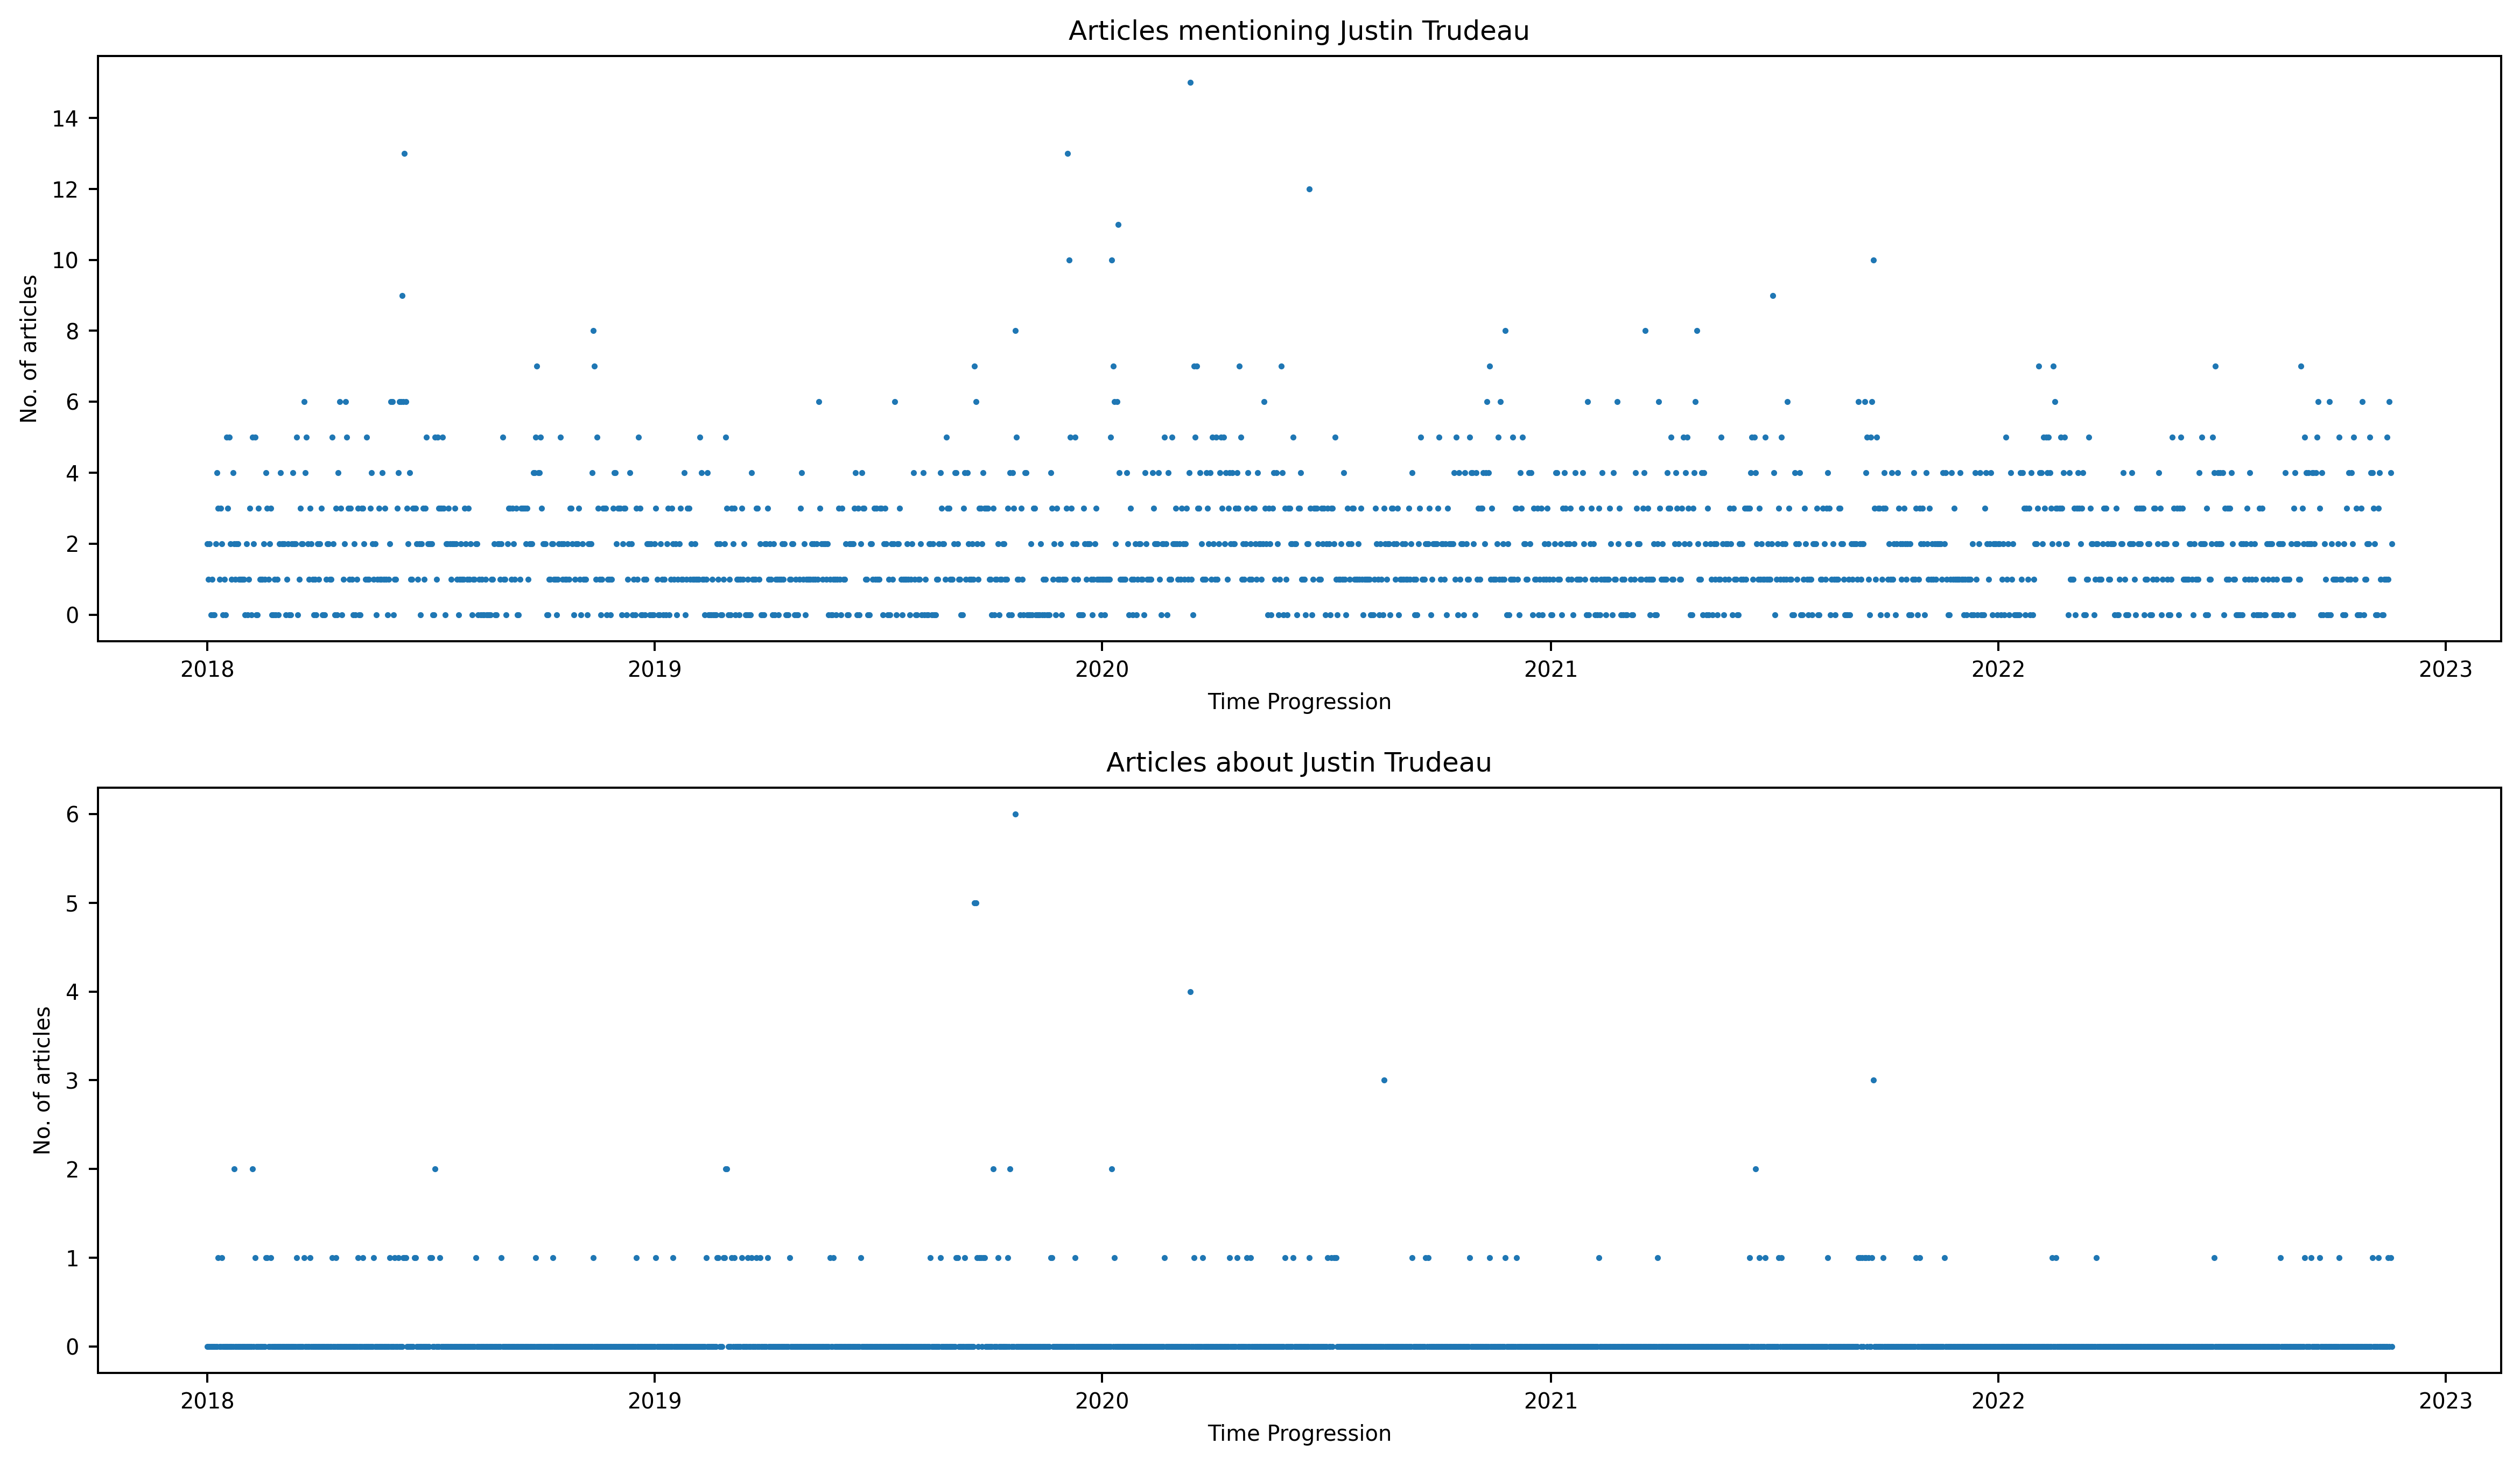

In [37]:
scatter_graph_frames(df_mentions,df_titles)

### _Question-6:_ Unusual Events in the time series

Let us define an unusual event as something that happens way beyond the average occurrence.
For this we already have seen the average articles per day and events more than average (until the maximum article count) and their corresponding probabilities are as follows:

We store them in a list and graph them against the occurrence to see any unusual events:

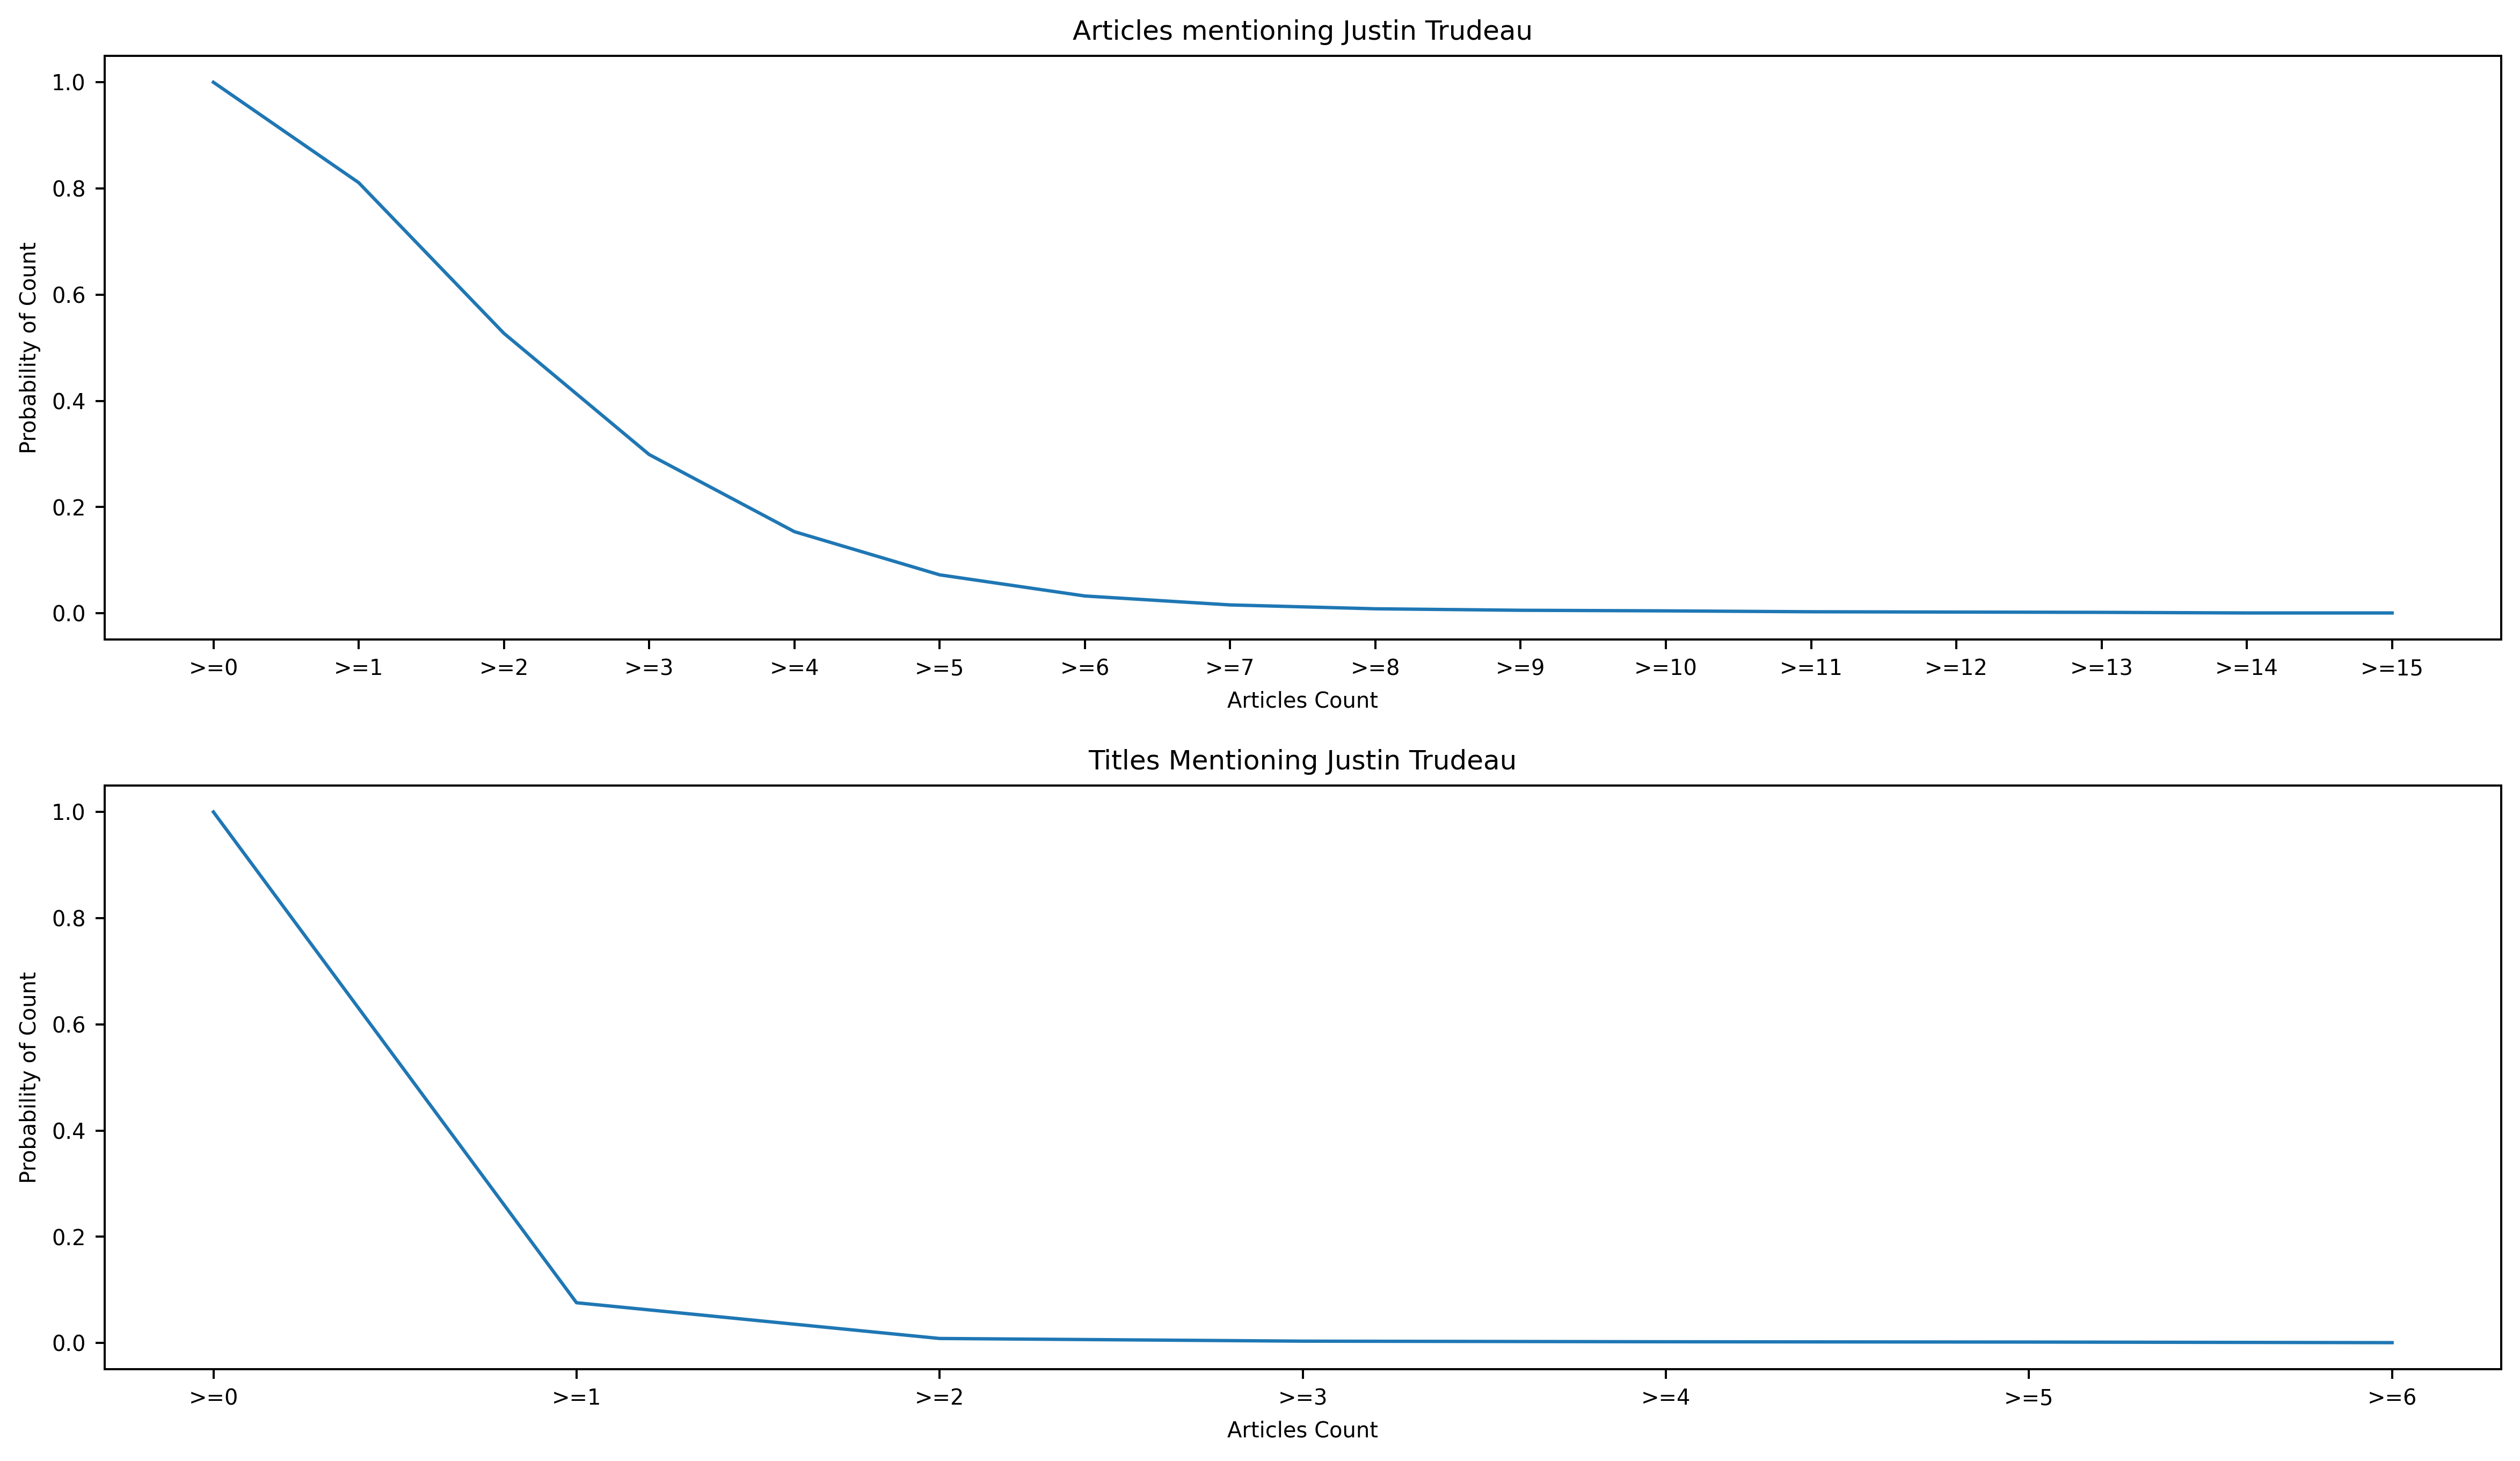

In [87]:
# Maximum of articles_count where Justin Trudeau has been mentioned either in the title or in the body of article
max_mentions = df_mentions['No. of Articles'].max()

# Maximum of articles_count where Justin Trudeau has been mentioned in the title
max_titles = df_titles['No. of Articles'].max()


prob_list_mentions = []
x_axis_mentions = []
articles_mentions = df_mentions['No. of Articles']

for i in range(0, max_mentions+1):
    Count = articles_mentions[articles_mentions >= i].count()
    x_axis_mentions.append(str(">="+str(i)))
    prob_list_mentions.append(Count/len(df_mentions))

#### Articles where Trudeau is mentioned in the Title

prob_list_titles = []
x_axis_titles = []
title_mentions = df_titles['No. of Articles']

for i in range(0, max_titles+1):
    Count = title_mentions[title_mentions >= i].count()
    x_axis_titles.append(str(">="+str(i)))
    prob_list_titles.append(Count/len(df_titles))


    
    #### Plotting Both ###
plt.figure(figsize=(16, 9), dpi=360)
SMALL_SIZE = 6
MEDIUM_SIZE = 8
POST_MEDIUM_SIZE = 10
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)

plt.subplot(2,1,1)

plt.title("Articles mentioning Justin Trudeau", fontsize=POST_MEDIUM_SIZE)
plt.xlabel("Articles Count", fontsize=MEDIUM_SIZE)
plt.ylabel("Probability of Count", fontsize=MEDIUM_SIZE)
plt.plot(x_axis_mentions, prob_list_mentions, linewidth='1.25')

plt.subplot(2,1,2)

plt.title("Titles Mentioning Justin Trudeau", fontsize=POST_MEDIUM_SIZE)
plt.xlabel("Articles Count", fontsize=MEDIUM_SIZE)
plt.ylabel("Probability of Count", fontsize=MEDIUM_SIZE)
plt.plot(x_axis_titles, prob_list_titles, linewidth='1.25')



plt.subplots_adjust(wspace=None, hspace=0.25)
plt.show()   

## _Question-7:_ Unusual Events

From the graphs, we can see that the state of being unusual is with the increasing number of articles per day.

In the top graph, we can see that most of the days, the number of articles being posted is zero - which is the event with the highest probability of occurrence over the time period. As the number of articles being posted each day start increasing, that event becomes more and more rare. Around the  **Elbow of the Graph** and afterward on the *X-Axis*, is where we can see the unusual events with the most unusual event towards the rightmost of the x-axis with the least probability of occurrence.

* that point for the top graph is approximately between 6 and 7 (we will use 7 for simplicity)
* that point for the bottom graph is 2

*It is rare that Articles containing Justin Trudeau (title and body) more than 7 a day*
*It is rare that Articles containing Justin Trudeau (title only) more than 2 a day*

Now I will extract the dates where this has happened and will have a look at the Titles to infer what might have been an unusual thing during that day.

__We will extract the dates where Article Count is more than 2 in both cases. Then we will make a new Data Frame containing the intersection of both Data Frames and we will see if that tells us anything__


In [98]:
unusual_mentions = df_mentions[df_mentions['No. of Articles'] > 2]

unusual_mentions

,Date,No. of Articles,Article_Names,Section
8,2018-01-09,4,[Cabinet reshuffle: Justine Greening quits the...,"[Politics, Politics, Opinion, UK news]"
9,2018-01-10,3,[The media should not settle for ‘truthiness’ ...,"[Opinion, World news, Technology]"
11,2018-01-12,3,[Debunked: Trump reasons for cancelling London...,"[US news, Opinion, Music]"
16,2018-01-17,5,[Justin Rose hits back at ‘boring golf’ tag – ...,"[Sport, Environment, Music, Politics, Politics]"
17,2018-01-18,3,[Tide Pod challenge: YouTube clamps down on 'd...,"[Technology, US news, Culture]"
...,...,...,...,...
1771,2022-11-07,3,[How can we cut soaring demand for meat? Try a...,"[Opinion, Music, World news]"
1772,2022-11-08,4,[Afternoon Update: Liberal senator’s ‘offensiv...,"[Australia news, Politics, Environment, Football]"
1778,2022-11-14,5,[G20 explainer: everything you need to know ab...,"[World news, World news, Politics, World news,..."
1780,2022-11-16,6,[SES assesses flood damage in NSW’s central we...,"[Australia news, Politics, Film, World news, W..."


In [97]:
unusual_titles = df_titles[df_titles['No. of Articles'] > 2]

unusual_titles

,Date,No. of Articles,Article_Names,Section
626,2019-09-19,5,[Justin Trudeau brownface: Canada PM apologise...,"[World news, World news, US news, Australia ne..."
627,2019-09-20,5,[Trudeau says he can't recall how many times h...,"[World news, US news, Opinion, World news, Wor..."
659,2019-10-22,6,[Justin Trudeau's victory is a death knell for...,"[World news, World news, World news, US news, ..."
802,2020-03-13,4,[Justin Trudeau in self-isolation after wife S...,"[World news, US news, World news, World news]"
960,2020-08-18,3,[Canada finance minister resigns amid charity ...,"[World news, World news, World news]"
1359,2021-09-21,3,[Canada election result: Trudeau wins third te...,"[World news, World news, World news]"


### CAUSE OF UN-USUAL EVENTS

One approach to infer the cause of these events is to see the common dates between both cases along with the common titles. Then we can try to see if those titles mean anything with respect to the dates.


In [131]:
for d in list(unusual_titles['Date']):
    print("Date : ", d)
    mentions_row = unusual_mentions.loc[unusual_mentions['Date'] == d]
    titles_row = unusual_titles.loc[unusual_titles['Date'] == d]

    article_names_mentions_set = set(list(np.concatenate(list(mentions_row['Article_Names']))))
    article_names_titles_set = set(list(np.concatenate(list(titles_row['Article_Names']))))
    
    common_articles = list(article_names_titles_set.intersection(article_names_mentions_set))
    print("COMMON ARTICLES: ")
    print('\n'.join(common_articles))
    print()

Date :  2019-09-19
COMMON ARTICLES: 
Justin Trudeau brownface: Canada PM apologises after image emerges
US briefing: Greta Thunberg, Justin Trudeau and a Trump whistleblower
How will Justin Trudeau's blackface photos affect Canada's election?
Morning mail: climate strike, Trudeau blackface, bird extinctions
Thursday briefing: Trudeau apologises for 'brownface' picture

Date :  2019-09-20
COMMON ARTICLES: 
US briefing: climate strike, Trump whistleblower and Justin Trudeau
Trudeau tries to shift focus from brownface images to gun control
Justin Trudeau’s blackface can’t be wiped away | Letters
Justin Trudeau's brownface scandal is bad. But voting him out isn't the solution | Moustafa Bayoumi
Trudeau says he can't recall how many times he wore blackface makeup

Date :  2019-10-22
COMMON ARTICLES: 
The Guardian view on the Canadian election: a win for Trudeau, but not a triumph | Editorial
US briefing: Trudeau's narrow win, GOP disunity and ocean acidification
Trudeau faces rough road as 

### _Question-8:_ Looking at the output above with respect to the Dates, Following are the causes of the *unusual* events:

#### 1) 2019, September 19th ( __CAUSE:__ *Photo Scandal* )

An old photo of Justin Trudeau emerged on social media showing him wearing black/dark brown make-up on his face as a part of the costume during a school party where he was a teacher. This caused an outrage which eventually made him apologise for it. The timing of the picture was odd given the upcoming Federal Elections for the year 2019 were to be held on October 21st and Justin Trudeau was the serving Prime Minister at the time.

Following 4 news articles are about Justin Trudeau and related to the Brown Face Incident:

* Justin Trudeau brownface: Canada PM apologises after image emerges
* How will Justin Trudeau's blackface photos affect Canada's election?
* Morning mail: climate strike, Trudeau blackface, bird extinctions
* Thursday briefing: Trudeau apologises for 'brownface' picture

While the following article mentions him and that event along with other news:

* US briefing: Greta Thunberg, Justin Trudeau and a Trump whistleblower

#### 2) 2019, September 20th ( __CAUSE:__ *Photo Scandal* )

In reference to the previous explanation, the talk related to his old photo in the light of upcoming elections was still going on and was pretty fresh in the press.

Following 4 news articles are about Justin Trudeau and related to the Brown Face Incident:

* Trudeau tries to shift focus from brownface images to gun control
* Justin Trudeau’s blackface can’t be wiped away | Letters
* Justin Trudeau's brownface scandal is bad. But voting him out isn't the solution | Moustafa Bayoumi
* Trudeau says he can't recall how many times he wore blackface makeup

While the following article mentions him and that event along with other news:

* US briefing: climate strike, Trump whistleblower and Justin Trudeau


#### 3) 2019, October 22th ( __CAUSE:__ *Canadian Federal Election 2019 and Trudeau's victory* )

The day after Canadian Federal Elections of 2019 which were won by Justin Trudeau by a narrow margin yet not gaining majority which is to have more than 35% of the seats. This led him to form a minority government in coalition.

The following 5 articles focus on Justin Trudeau's election victory and the supposed situations to follow:

* The Guardian view on the Canadian election: a win for Trudeau, but not a triumph | Editorial
* Trudeau faces rough road as Canada's minority parties lay out their conditions
* Canada election 2019: 'We'll govern for everyone' says Trudeau, after narrow win – as it happened
* Justin Trudeau's victory is a death knell for Canada's fledgling far-right
* Canada elections: Trudeau wins narrow victory to form minority government


The following article mentions briefly his electoral victory along with other topics:

* US briefing: Trudeau's narrow win, GOP disunity and ocean acidification



#### 4) 2020, March 13th ( __CAUSE:__ *Justin Trudeau Testing Positive for COVID* )

Justin Trudeau tested positive for corona virus along with his wife and goes into self quarantine. The other article in the same relation to the news mentions Trudeau's approach for tackling Corona virus situation in Canada

The following 2 articles focus on Justin Trudeau's covid infection andelection victory and the supposed situations to follow:

* Justin Trudeau in self-isolation after wife Sophie tests positive for coronavirus
* Justin Trudeau announces sweeping steps to tackle coronavirus in Canada

The following 2 articles mentions Trudeau's wife's possible contact point for getting infected in relation to Justin Trudeau's covid positive news and the about Trudeau's quarantine being mentioned along with two other news in the same article:

* Fears grow Sophie Grégoire Trudeau picked up coronavirus on London trip
* US briefing: Trudeau quarantined, Iran mass graves and Chelsea Manning




#### 5) 2020, August 18th ( __CAUSE:__ *WE Charity Scandal, Parliament Prorogation, Bill Morneau's Resignation* )

Justin Trudeau's Finance Minister Bill Morneau's name came up along with Prime Minister's related to WE Charity scandal. Trudeau prorogued the parliament, as done in the past, to avoid political scrutiny. The following three articles revolve around this issue:

* Canada: departure of finance minister suggests Trudeau will pursue ‘green’ recovery plan
* Trudeau accused of attempting to cover up scandal by proroguing parliament
* Canada finance minister resigns amid charity scandal and reports of tensions with Trudeau




#### 6) 2021, September 21st ( __CAUSE:__ *Federal Elections Canada 2021 and Trudeau's victory* )

Justin Trudeau's called for early elections amidst the Corona crisis seeking public mandate. He secured a third victory in the office and the following three articles are related to this event:

* Trudeau didn’t win the majority but still has chance to pass sweeping legislation
* Justin Trudeau secures a third victory in an election ‘nobody wanted’
* Canada election result: Trudeau wins third term after early vote gamble


#### DAILY AUTOMATED JOB

For this purpose, we use the schedule package. We set the task to execute at 9:00 am everyday.



For this part, please see the file __"scheduled_guardian.py"__

It runs the task and saves the time evolution graphs of the data which could be sent to recipients who have not seen the data before